<a href="https://colab.research.google.com/github/wickkiey/Distributed-Training/blob/main/tf2_approach/TF_Mirrored_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Distributed training with Keras with Mirrored Strategy


In [28]:
# Import TensorFlow and TensorFlow Datasets

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import os

In [2]:
print(tf.__version__)

2.4.1


## Download the dataset

In [3]:
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = datasets['train'], datasets['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [8]:
## Dataset Details
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



## Define distribution strategy

In [4]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [5]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


## Setup input pipeline

In [9]:
# You can also do info.splits.total_num_examples to get the total
# number of examples in the dataset.

num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [10]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label

In [11]:
train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

## Create the model

Create and compile the Keras model in the context of `strategy.scope`.

In [13]:
with strategy.scope():
  mirrored_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
  ])

  mirrored_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [14]:
default_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
])

default_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Model Graph

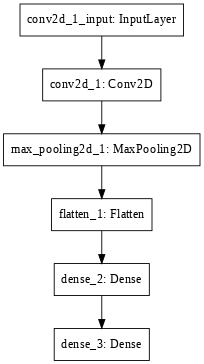

In [31]:
plot_model(mirrored_model,dpi=64)

## Define the callbacks


In [15]:
# Define the checkpoint directory to store the checkpoints

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [16]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

In [21]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      mirrored_model.optimizer.lr.numpy()))

In [22]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    #tf.keras.callbacks.LearningRateScheduler(decay),
    #PrintLR()
]

## Train and evaluate

Now, train the model in the usual way, calling `fit` on the model and passing in the dataset created at the beginning of the tutorial. This step is the same whether you are distributing the training or not.


In [23]:
%%time
history = mirrored_model.fit(train_dataset, epochs=12, callbacks=callbacks)

Epoch 1/12
938/938 [==============================] - 3s 3ms/step - loss: 0.0665 - accuracy: 0.9808
Epoch 2/12
938/938 [==============================] - 3s 3ms/step - loss: 0.0476 - accuracy: 0.9857
Epoch 3/12
938/938 [==============================] - 3s 3ms/step - loss: 0.0351 - accuracy: 0.9892
Epoch 4/12
938/938 [==============================] - 3s 3ms/step - loss: 0.0270 - accuracy: 0.9916
Epoch 5/12
938/938 [==============================] - 3s 3ms/step - loss: 0.0203 - accuracy: 0.9937
Epoch 6/12
938/938 [==============================] - 3s 3ms/step - loss: 0.0154 - accuracy: 0.9948
Epoch 7/12
938/938 [==============================] - 3s 3ms/step - loss: 0.0132 - accuracy: 0.9958
Epoch 8/12
938/938 [==============================] - 3s 3ms/step - loss: 0.0106 - accuracy: 0.9966
Epoch 9/12
938/938 [==============================] - 3s 3ms/step - loss: 0.0069 - accuracy: 0.9980
Epoch 10/12
938/938 [==============================] - 3s 3ms/step - loss: 0.0064 - accuracy: 0.9980

In [24]:
%%time
history1 = default_model.fit(train_dataset, epochs=12, callbacks=callbacks)

Epoch 1/12
938/938 [==============================] - 3s 3ms/step - loss: 0.4015 - accuracy: 0.8823
Epoch 2/12
938/938 [==============================] - 2s 2ms/step - loss: 0.0736 - accuracy: 0.9779
Epoch 3/12
938/938 [==============================] - 2s 2ms/step - loss: 0.0501 - accuracy: 0.9857
Epoch 4/12
938/938 [==============================] - 2s 2ms/step - loss: 0.0367 - accuracy: 0.9890
Epoch 5/12
938/938 [==============================] - 2s 2ms/step - loss: 0.0271 - accuracy: 0.9913
Epoch 6/12
938/938 [==============================] - 2s 2ms/step - loss: 0.0213 - accuracy: 0.9935
Epoch 7/12
938/938 [==============================] - 2s 2ms/step - loss: 0.0177 - accuracy: 0.9947
Epoch 8/12
938/938 [==============================] - 2s 2ms/step - loss: 0.0148 - accuracy: 0.9949
Epoch 9/12
938/938 [==============================] - 2s 2ms/step - loss: 0.0111 - accuracy: 0.9963
Epoch 10/12
938/938 [==============================] - 2s 2ms/step - loss: 0.0089 - accuracy: 0.9971

# Visualize and Compare

In [25]:
import matplotlib.pyplot as plt



[]

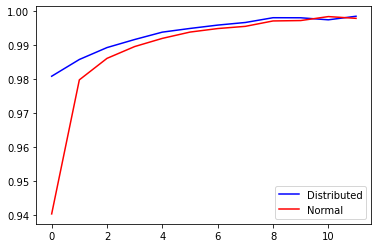

In [26]:
plt.plot(history.history['accuracy'],color='blue',label="Distributed")
plt.plot(history1.history['accuracy'],color='red', label="Normal")
plt.legend()
plt.plot()